## Loading data products

- Load remote data for desired moorings
- Write data locally
- Extract a single timeseries at the deepest well-sampled depth for each mooring 

Using the [loading_data_products.ipynb](loading_data_products.ipynb) notebook as a starting point.

In [1]:
import sys

sys.path.insert(0, "../sa_upwelling")   # Allows using the files in the Python package
import utils

from matplotlib import pyplot as plt

SA coastal moorings that are active: 
* SAM8SG
* SAM5CB
* NRSKAI (National Reference Station Kangaroo Island, NRS division)

SA coastal moorings that are not active but have data available:
* SAM2CP
* SAM6IS
* SAM3MS
* SAM7DS

**Notes:**
* Look at TS for details: https://imos.org.au/fileadmin/user_upload/shared/ANMN/SA_Moorings/06c._Southern_Australia_Moorings_-_TS.pdf
* Aggregate has data only from termistor
* Avoid CTD-derived data (look out for anomalies)


### Hourly time-series

If you are running this for the first time, it might take a while as data is downloaded.

In [2]:
hourly_files, hourly_datasets = utils.load_data_products()

Loading local hourly-timeseries data for mooring 'NRSKAI'.
Loading local hourly-timeseries data for mooring 'SAM8SG'.
Loading local hourly-timeseries data for mooring 'SAM5CB'.
Loading local hourly-timeseries data for mooring 'SAM2CP'.
Loading local hourly-timeseries data for mooring 'SAM6IS'.
Loading local hourly-timeseries data for mooring 'SAM3MS'.
Loading local hourly-timeseries data for mooring 'SAM7DS'.


**Datasets can be accessed by using the `hourly_datasets` dictionary.**

## Extract all temperature timeseries and save to CSV

In [3]:
# Run the extraction function for all sites, saving to CSV and storing the
# timeseries DataFrames in a local variable for subsequent use

temp_timeseries = dict()
for mooring in hourly_datasets.keys():
    ds = hourly_datasets[mooring]
    df = utils.extract_timeseries_df(ds, save=True)
    temp_timeseries[mooring] = df

Saved timeseries to ../Datasets/NRSKAI_TEMP_101-111m.csv
Saved timeseries to ../Datasets/SAM8SG_TEMP_38-48m.csv
Saved timeseries to ../Datasets/SAM5CB_TEMP_90-100m.csv
Saved timeseries to ../Datasets/SAM2CP_TEMP_90-100m.csv
Saved timeseries to ../Datasets/SAM6IS_TEMP_73-83m.csv
Saved timeseries to ../Datasets/SAM3MS_TEMP_158-168m.csv
Saved timeseries to ../Datasets/SAM7DS_TEMP_512-522m.csv


## Plot all timeseries

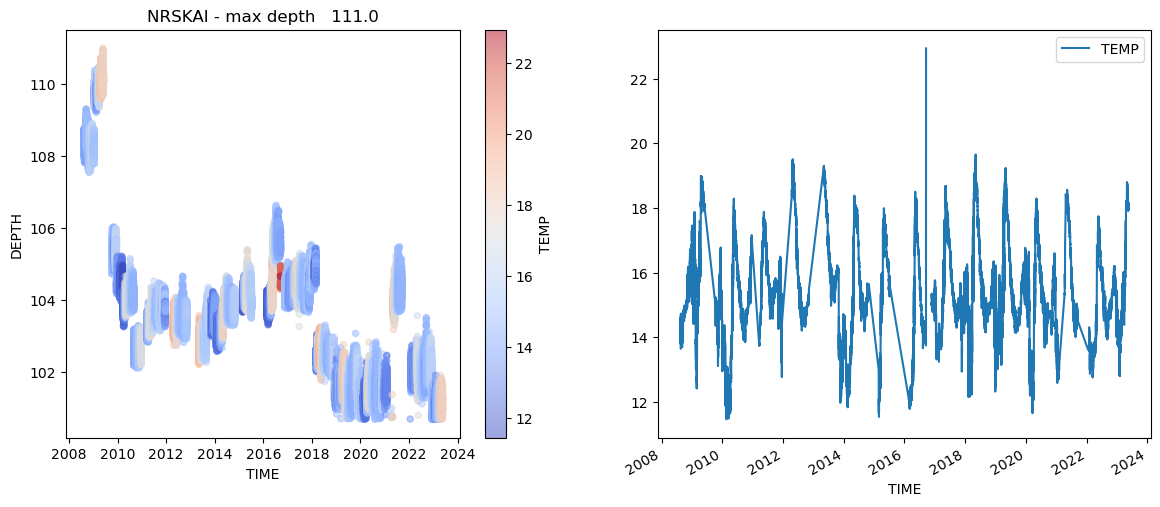

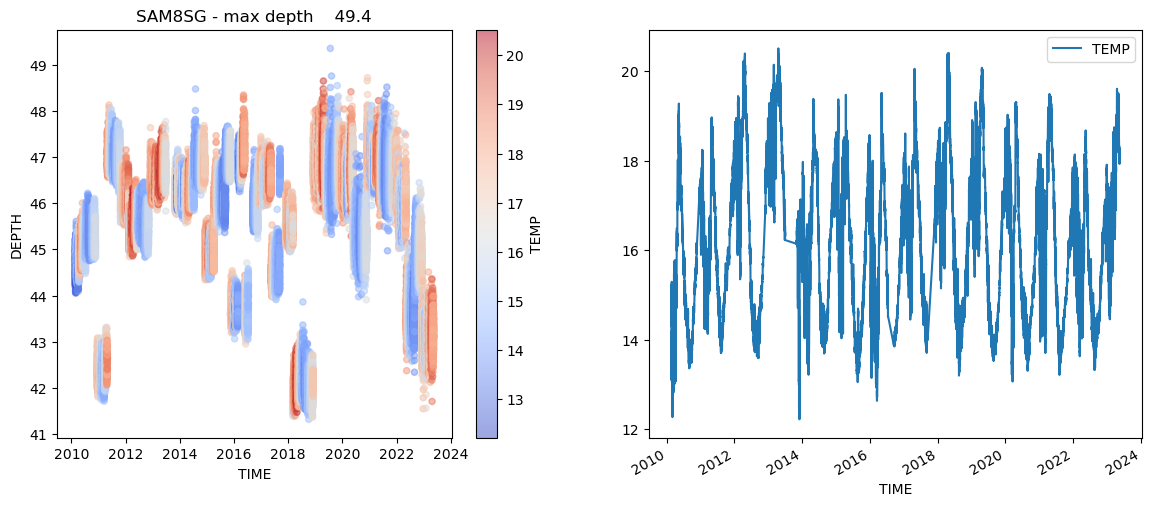

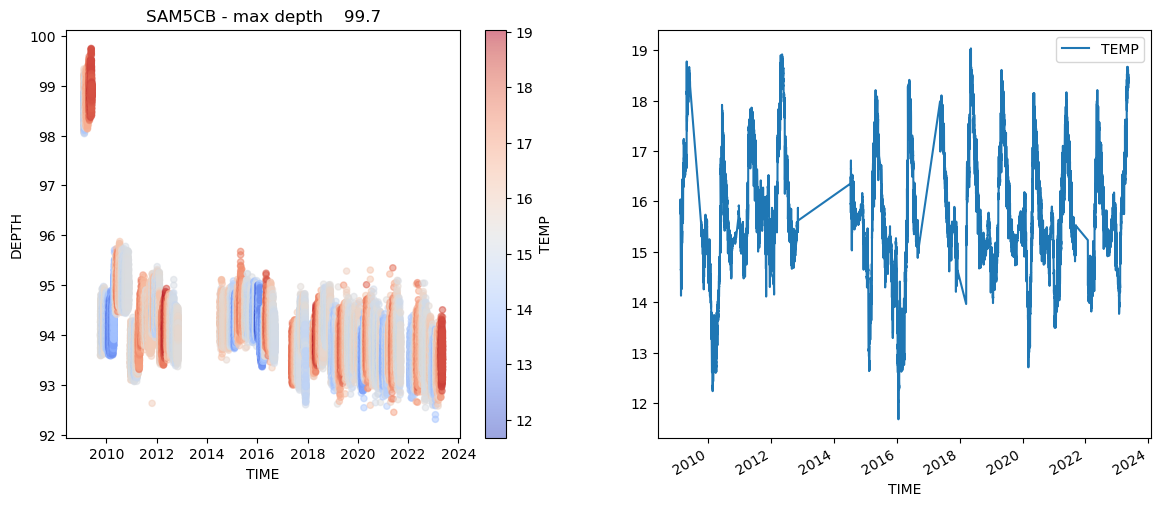

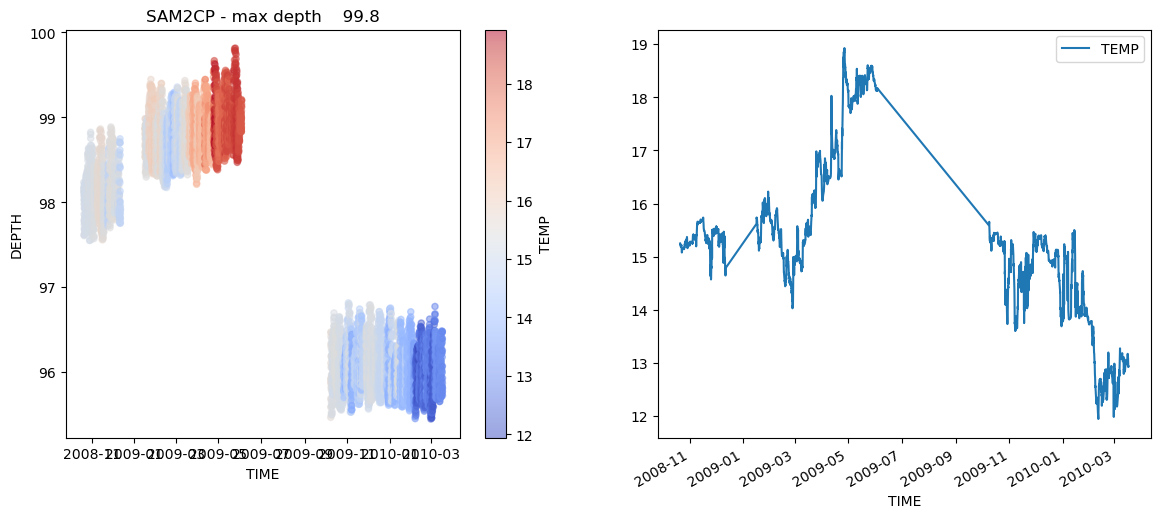

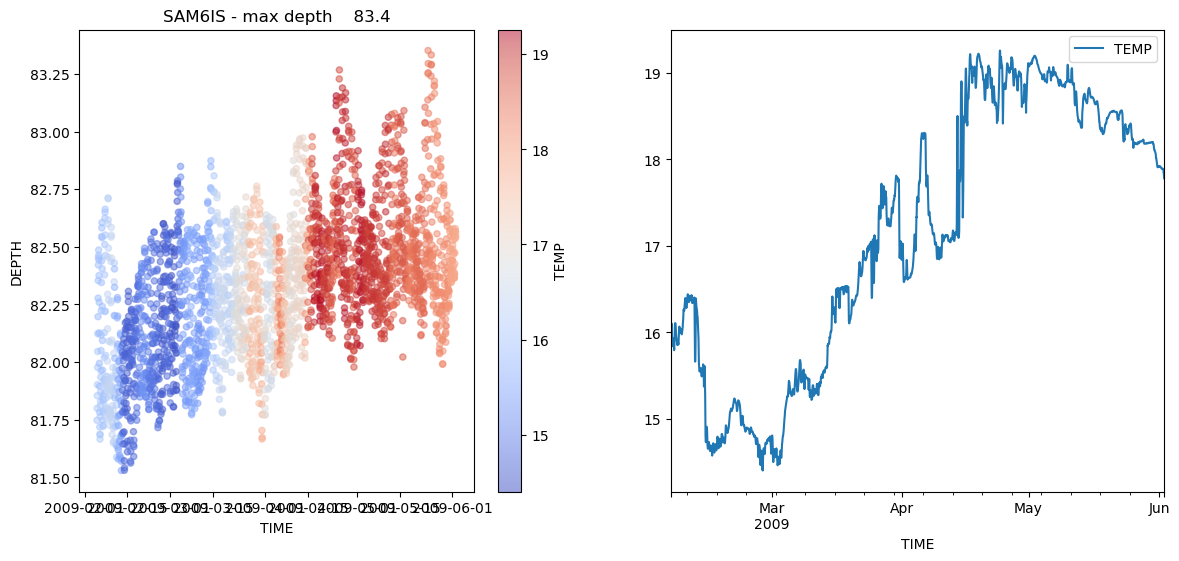

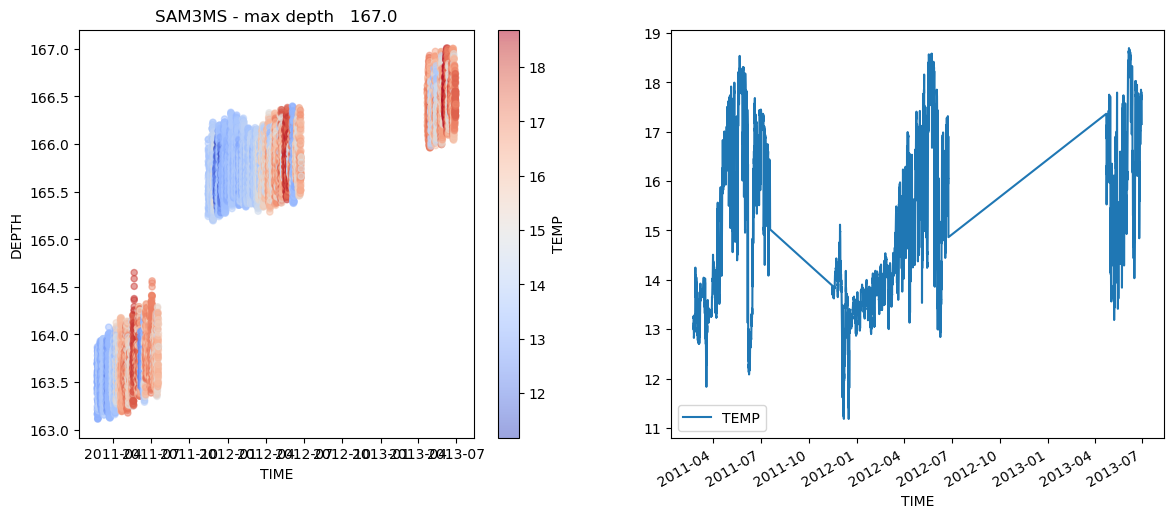

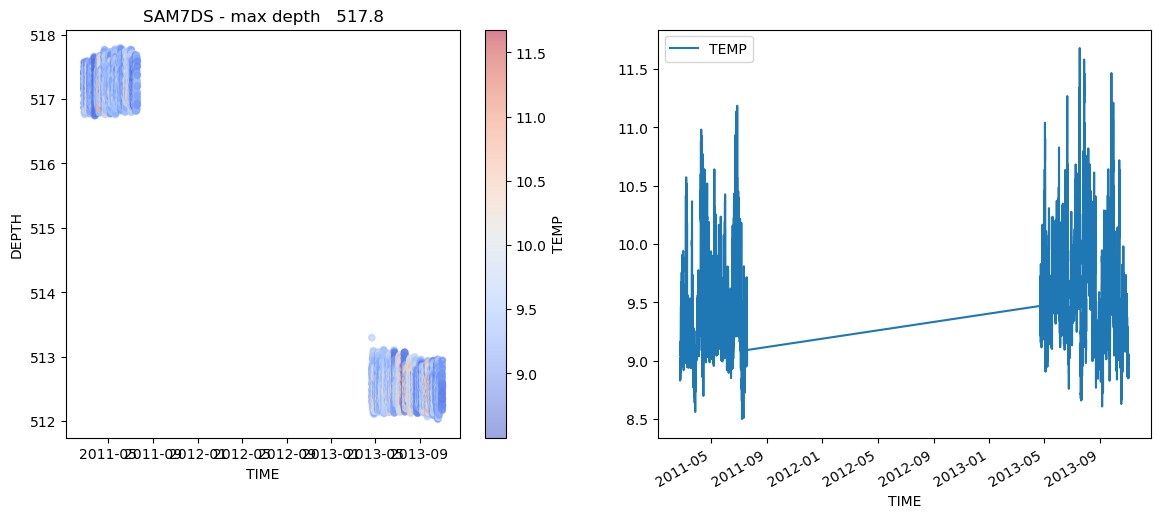

In [4]:
def plot_bottom_temp(mooring):
    """Plot the temperature values from the bottom 10m of the mooring
    """
    df = temp_timeseries[mooring]
    dmax = df.DEPTH.max()
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    df.plot.scatter(x="TIME", y="DEPTH", c="TEMP", cmap="coolwarm", alpha=0.5,
                   title=f"{mooring} - max depth {dmax:7.1f}", ax=axs[0])
    df.plot(x="TIME", y="TEMP", ax=axs[1])
    
for mooring in hourly_datasets.keys():
    plot_bottom_temp(mooring)